# Exploration, Enhancement, Visualization of Chicago Rideshare Dataset


## Step 1:  Import Rideshare Data

In [61]:
%config IPCompleter.greedy=True

In [2]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import requests
import ipywidgets as widgets

In [3]:
%%time
#Get data - either sample 12 GB file or load pre-sampled data
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'
firstrun=False#False #set to true to reimport dataset from csv
if firstrun:
    iterdf=pd.read_csv(os.path.join(datadir,'Transportation_Network_Providers_-_Trips.csv'),chunksize=200000)
    #dataset has 40 million records
    samp_df=pd.DataFrame()
    #sample 5% of df and make new df
    for chunk in iterdf:
        samp_df=samp_df.append(chunk.sample(frac=0.05)) #5% of rides
    samp_df=samp_df.dropna(how='any')
    samp_df.columns = ['TripID', 'TripStart', 'TripEnd', 'TripSeconds',
           'TripMiles', 'PUCensusTract', 'DOCensusTract',
           'PUCommunityArea', 'DOCommunityArea', 'Fare', 'Tip',
           'AdditionalCharges', 'TripTotal', 'SharedTripAuth',
           'TripsPooled', 'PU_Lat', 'PU_Long','PU_Geo', 'DO_Lat',
           'DO_Long', 'DO_Geo'] #PU=pick up, DO=drop off
    samp_df['TripStart']=pd.to_datetime(samp_df['TripStart'],infer_datetime_format=True)
    samp_df['TripEnd']=pd.to_datetime(samp_df['TripEnd'],infer_datetime_format=True)
    samp_df.head()
    #this took a long time, saving output
    samp_df.to_pickle(os.path.join(datadir,'chicago_pickle_05'))
else:
    samp_df=pd.read_pickle(os.path.join(datadir,'chicago_pickle_05')) 

CPU times: user 782 ms, sys: 798 ms, total: 1.58 s
Wall time: 2.32 s


In [64]:
#inspect raw import
samp_df.iloc[:2,:15]


,TripID,TripStart,TripEnd,TripSeconds,TripMiles,PUCensusTract,DOCensusTract,PUCommunityArea,DOCommunityArea,Fare,Tip,AdditionalCharges,TripTotal,SharedTripAuth,TripsPooled
133854,b7d58e1e960991c5782a106372dde8a461280832,2018-11-23 19:00:00,2018-11-23 19:15:00,1009.0,4.5,1.703124e+10,1.703183e+10,24.0,6.0,10.0,0.0,2.5,12.5,False,1
68868,b6027701346eab0f8b86fd4a4b109822a378c791,2018-12-19 19:45:00,2018-12-19 20:00:00,860.0,3.1,1.703184e+10,1.703107e+10,32.0,7.0,7.5,0.0,2.5,10.0,False,1


## Step 2:  Rideshare Wrangling
* Create fields for DOW, Month, Hour
* Convert census tract from float to string
* Round datetime fields to nearest hour
* Aggregate by tract, datetime and compute total ride counts and average fare/dist/duration


In [65]:
#convert census tract fields from float to string
samp_df['PUCensusTract']=samp_df.PUCensusTract.astype(int).astype(str)
samp_df['DOCensusTract']=samp_df.DOCensusTract.astype(int).astype(str)


In [66]:
#round times to nearest hour
samp_df['TripStart']=samp_df.TripStart.dt.round('H')
samp_df['TripEnd']=samp_df.TripEnd.dt.round('H')
#Previously derived these fields in wrangling section after agg 
samp_df['Year']=samp_df.TripStart.dt.year
samp_df['Month']=samp_df.TripStart.dt.month
samp_df['DOW']=samp_df.TripStart.dt.dayofweek
samp_df['Hour']=samp_df.TripStart.dt.hour


In [67]:
#remove rides where fare is zero
samp_df=samp_df.loc[(samp_df.Fare>0)&(samp_df.TripMiles>0)]

In [68]:
#export reformatted sample df
samp_df.to_pickle(os.path.join(datadir,'sampled_reformatted_df'))

In [69]:
#group by tract and trip start time (hourly)
grp_df=samp_df.groupby(['PUCensusTract','TripStart'])['Fare','Tip','AdditionalCharges','TripTotal','TripMiles','TripSeconds','Year','Month','DOW','Hour']
agg_avg=grp_df.mean()
agg_count=grp_df.size() 
agg_count=agg_count.rename('NumRides') #this is number of rides per hour in sampled dataset, multiply by 20 for actual rides
agg_df=agg_avg.join(agg_count) #join averages and count fields

In [70]:
#another workflow for aggregation, avoids join
fields2avg=['Fare','Tip','AdditionalCharges','TripTotal','TripMiles','TripSeconds','Year','Month','DOW','Hour']
aggdict=dict(zip(fields2avg,['mean']*len(fields2avg)))
aggdict['Hour']=['mean','size']
grp_df.agg(aggdict).head()


Fare  Tip AdditionalCharges TripTotal  \
                                    mean mean              mean      mean   
PUCensusTract TripStart                                                     
17031010100   2018-11-01 16:00:00   5.00  0.0               2.5      7.50   
              2018-11-02 07:00:00  11.25  0.0               2.5     13.75   
              2018-11-02 15:00:00   7.50  0.0               0.0      7.50   
              2018-11-02 16:00:00   7.50  0.0               2.5     10.00   
              2018-11-02 19:00:00  17.50  0.0               2.5     20.00   

                                  TripMiles TripSeconds  Year Month  DOW Hour  \
                                       mean        mean  mean  mean mean mean   
PUCensusTract TripStart                                                         
17031010100   2018-11-01 16:00:00      1.90       683.5  2018    11    3   16   
              2018-11-02 07:00:00      5.75      1005.5  2018    11    4    7   
              2018-11-02 15:00:00      1.80       548.0  2018    11    4   15   
              2018-11-02 16:00:00      3.20       900.0  2018    11    4   16   
              2018-11-02 19:00:00     11.30      2238.5  2018    11    4   19   

                                        
                                  size  
PUCensusTract TripStart                 
17031010100   2018-11-01 16:00:00    2  
              2018-11-02 07:00:00    2  
              2018-11-02 15:00:00    1  
              2018-11-02 16:00:00    1  
              2018-11-02 19:00:00    2

In [71]:
#reclassify into blocks of time?  early morning, late morning, etc.
#add day type:  weekday, weekend, holiday 

In [72]:
#inspct aggregated DF
agg_df.head()

Fare  Tip  AdditionalCharges  TripTotal  \
PUCensusTract TripStart                                                       
17031010100   2018-11-01 16:00:00   5.00  0.0                2.5       7.50   
              2018-11-02 07:00:00  11.25  0.0                2.5      13.75   
              2018-11-02 15:00:00   7.50  0.0                0.0       7.50   
              2018-11-02 16:00:00   7.50  0.0                2.5      10.00   
              2018-11-02 19:00:00  17.50  0.0                2.5      20.00   

                                   TripMiles  TripSeconds  Year  Month  DOW  \
PUCensusTract TripStart                                                       
17031010100   2018-11-01 16:00:00       1.90        683.5  2018     11    3   
              2018-11-02 07:00:00       5.75       1005.5  2018     11    4   
              2018-11-02 15:00:00       1.80        548.0  2018     11    4   
              2018-11-02 16:00:00       3.20        900.0  2018     11    4   
              2018-11-02 19:00:00      11.30       2238.5  2018     11    4   

                                   Hour  NumRides  
PUCensusTract TripStart                            
17031010100   2018-11-01 16:00:00    16         2  
              2018-11-02 07:00:00     7         2  
              2018-11-02 15:00:00    15         1  
              2018-11-02 16:00:00    16         1  
              2018-11-02 19:00:00    19         2

## Step 3:  Merge additional datasets
### Import weather data (downloaded from NOAA) and join to hourly aggregated rideshare data

In [4]:
weathcsv='/Users/rtaylor/Desktop/Springboard/DataSets/Climate/ChicagoMidway.csv'
weath_df=pd.read_csv(weathcsv)
weath_df.index=pd.DatetimeIndex(weath_df.DATE)
del weath_df['DATE']

#extract daily records (may not need)
weath_daily=weath_df.loc[weath_df.DailyAverageDryBulbTemperature.notnull(),['DailyAverageDryBulbTemperature','DailyAverageWindSpeed','DailyPrecipitation']]
weath_daily.columns=['DTemp','DWind','DPrecip']
weath_daily['DTemp']=pd.to_numeric(weath_daily['DTemp'],errors='coerce').fillna(method='ffill')
weath_daily['DPrecip']=pd.to_numeric(weath_daily['DPrecip'],errors='coerce').fillna(0)
weath_daily.index=weath_daily.index.normalize()
weath_daily.head()
weath_daily.to_csv(os.path.join(datadir,'daily_weather_extract.csv'))

#extract hourly records
weath_hourly=weath_df.loc[weath_df.HourlyDryBulbTemperature.notnull(),['HourlyDryBulbTemperature','HourlyWindSpeed','HourlyPrecipitation']]
weath_hourly.columns=['HTemp','HWind','HPrecip']
weath_hourly['HTemp']=pd.to_numeric(weath_hourly['HTemp'],errors='coerce').fillna(method='ffill') #check to see if these should have been interpolated instead
weath_hourly['HPrecip']=pd.to_numeric(weath_hourly['HPrecip'],errors='coerce').fillna(0)
weath_hourly['HWind']=pd.to_numeric(weath_hourly['HWind'],errors='coerce').fillna(0)
weath_hourly['Precip']=weath_hourly.HPrecip.apply(lambda x: 'Wet' if x>0.01 else 'Dry')

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (35,36,52,56,58,59,71,119) have mixed types. Specify dtype option on import or set low_memory=False.



In [74]:
weath_hourly.head()

,HTemp,HWind,HPrecip,Precip
DATE,,,,
2018-10-01 00:53:00,59.0,9.0,0.0,Dry
2018-10-01 01:53:00,59.0,11.0,0.0,Dry
2018-10-01 02:53:00,58.0,13.0,0.0,Dry
2018-10-01 03:00:00,58.0,13.0,0.0,Dry
2018-10-01 03:53:00,58.0,8.0,0.0,Dry


In [75]:
#use asof merge to join weather to hourly rides
agg_df_reindex=agg_df.reset_index().sort_values('TripStart')
agg_df_weather=pd.merge_asof(agg_df_reindex,weath_hourly,left_on='TripStart',right_index=True) #default is backwards search
agg_df_weather=agg_df_weather.sort_values(['PUCensusTract','TripStart']).set_index(['PUCensusTract','TripStart'])

(737060.0, 737110.0)

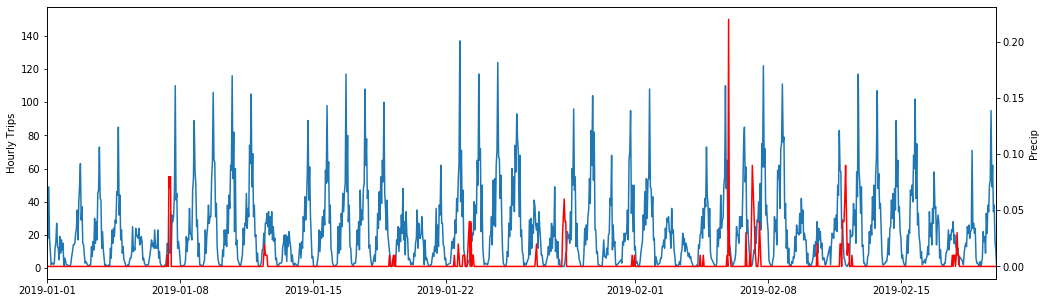

In [76]:
#look at data from one tract (downtown) concurrently with precip
onetract=agg_df_weather.loc['17031839100']
fig,ax=plt.subplots(figsize=(17,5))
ax.plot(onetract.index,onetract['NumRides'])
#ax.plot(onetract.index,onetract.HTemp,color='k')
ax2 = ax.twinx() 
ax2.plot(onetract.index,onetract.HPrecip,color='r')
ax.set_ylabel('Hourly Trips')
ax2.set_ylabel('Precip')
ax.set_xlim([pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2019-02-20 00:00:00')])

In [77]:
#is there a change in rides due to weather?
#possible increase in ride frequency, decrease in average distance/duration in rain/snow
agg_df_weather.groupby('Precip')['Fare','NumRides','TripMiles','TripSeconds'].describe().transpose()

Precip                       Dry           Wet
Fare        count  518129.000000  19251.000000
            mean        9.380689      9.483225
            std         5.560926      5.823797
            min         2.500000      2.500000
            25%         5.625000      5.833333
            50%         7.500000      7.500000
            75%        11.166667     11.250000
            max       180.000000     92.500000
NumRides    count  518129.000000  19251.000000
            mean        2.823949      3.093969
            std         4.494878      4.790852
            min         1.000000      1.000000
            25%         1.000000      1.000000
            50%         1.000000      1.000000
            75%         3.000000      3.000000
            max       150.000000     90.000000
TripMiles   count  518129.000000  19251.000000
            mean        4.741150      4.586204
            std         3.736996      3.653615
            min         0.100000      0.100000
            25%         2.300000      2.200000
            50%         3.650000      3.500000
            75%         5.900000      5.600000
            max        98.700000     37.400000
TripSeconds count  518129.000000  19251.000000
            mean      984.529997    980.402367
            std       595.392613    611.484143
            min         0.000000     19.000000
            25%       596.500000    590.000000
            50%       849.500000    834.600000
            75%      1229.000000   1209.000000
            max     72420.000000   9297.000000

### Join in Census Tract Geodata to enable mapping by tract usage
Census data comes at various levels of aggregation.
The rideshare data is grouped at the census tract level.
Census tract >  block group > block 
* Need to add flag for tract is airport

In [78]:
censtracts=gpd.read_file(os.path.join(datadir,'Boundaries - Census Tracts - 2010.geojson'))
censtracts=censtracts.set_index('geoid10')

In [79]:
#which census tracts are the largest overall source of rider pickups?
usage=samp_df.groupby('PUCensusTract').size()
usage=usage.rename('usage')

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning:

The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.



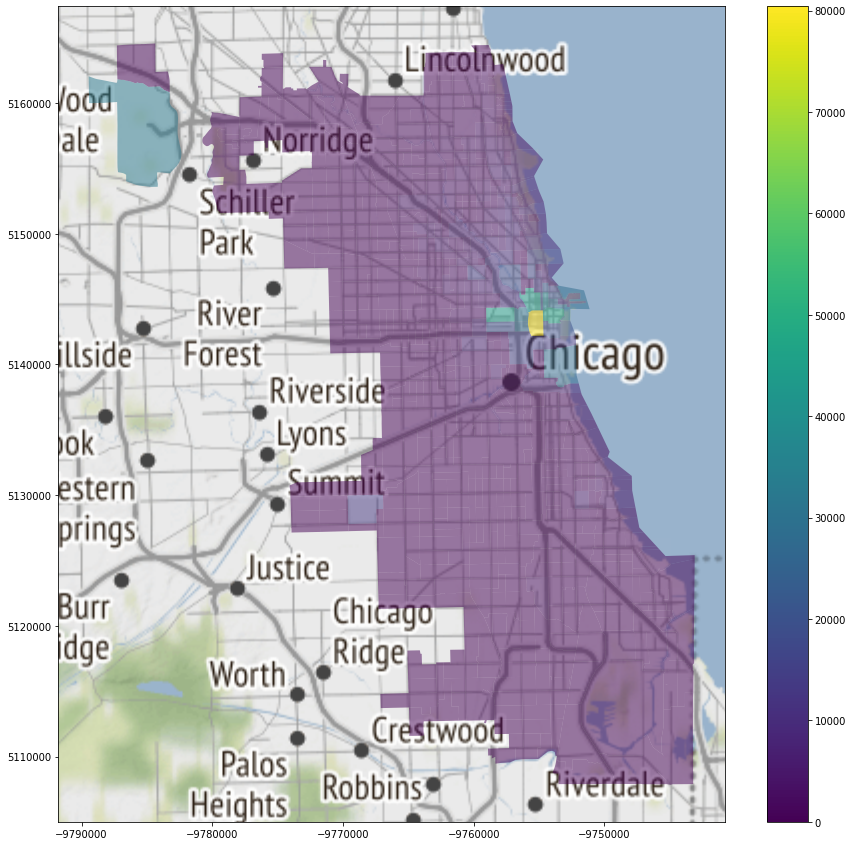

In [80]:
#join usage to census geo and map overall PU usage by tract
#need to convert this workflow to a function
usage_by_census_geo=censtracts.join(usage,how='left')
usage_by_census_geo['usage']=usage_by_census_geo['usage'].fillna(0)
usage_by_census_geo= usage_by_census_geo.to_crs(epsg=3857) #convert wgs84 to wms

#basemap function copied from geopandas documentation
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
fig,ax=plt.subplots(figsize=(15,15))
usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride sources are downtown and O'Hare airport

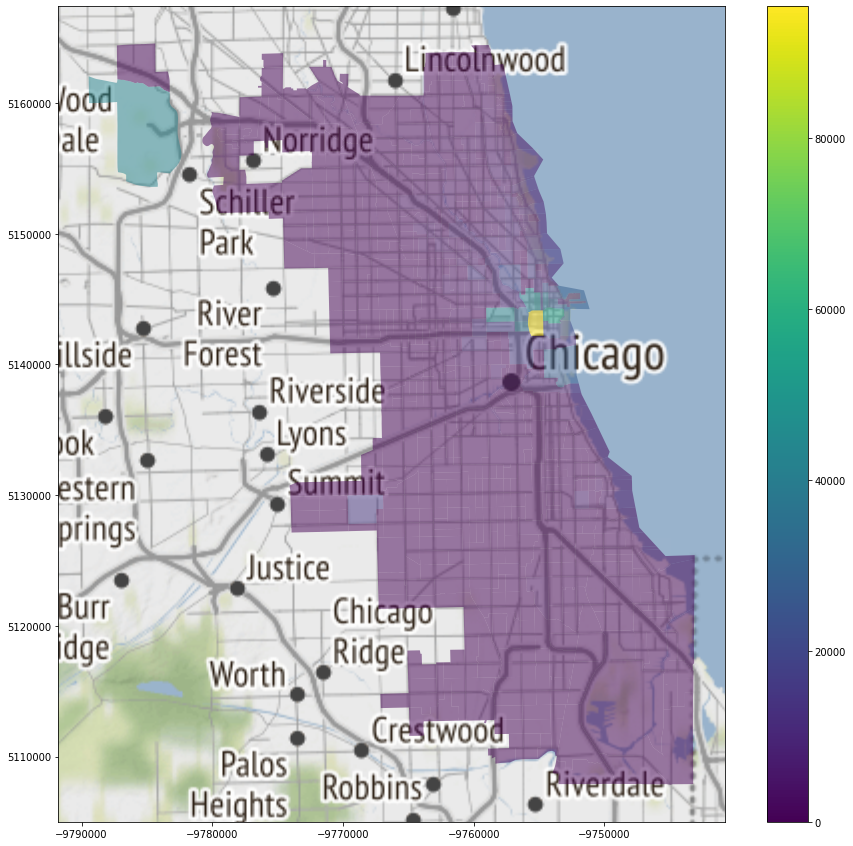

In [81]:
#Same analysis for destinations

#which census tracts are the largest overall rider destinations?
do_usage=samp_df.groupby('DOCensusTract').size()
do_usage=do_usage.rename('usage')
#join usage to census geo
do_usage_by_census_geo=censtracts.join(do_usage,how='left')
do_usage_by_census_geo['usage']=do_usage_by_census_geo['usage'].fillna(0)
do_usage_by_census_geo= do_usage_by_census_geo.to_crs(epsg=3857) #convert to wms
    
fig,ax=plt.subplots(figsize=(15,15))
do_usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride destinations are also downtown and O'Hare airport

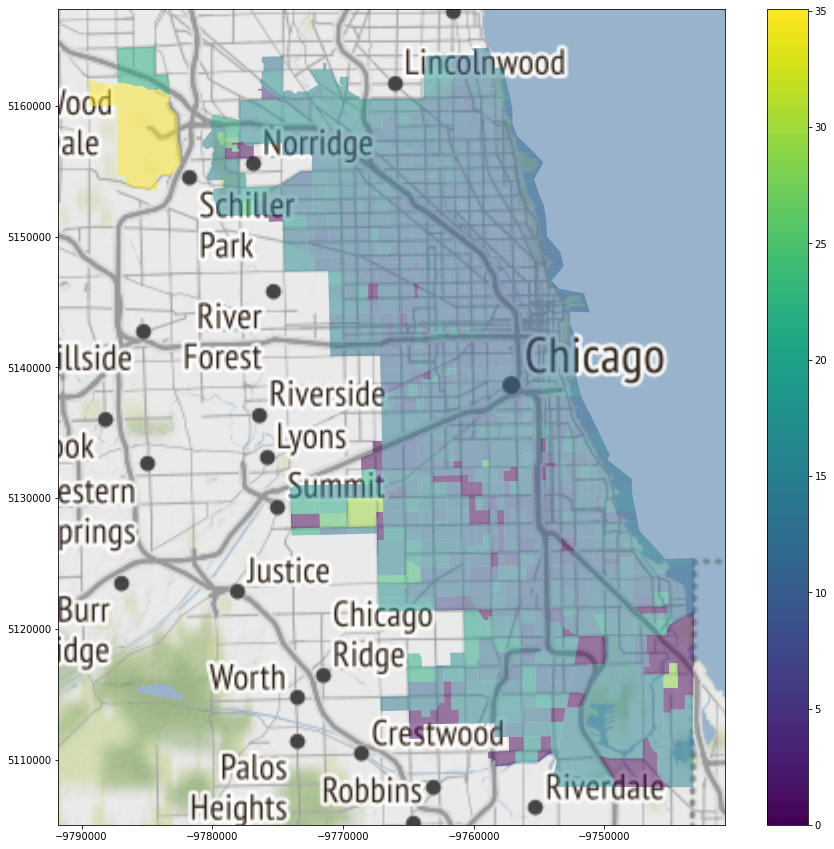

In [82]:
# Look at average fare by pickup locations:  weekend evening pickups

am_df=samp_df.loc[(samp_df.Hour.between(18,22))&(samp_df.DOW.between(5,7))]
am_pu_usage=am_df.groupby('PUCensusTract')['TripTotal'].mean()#.size()
am_pu_usage=am_pu_usage.rename('usage')
#join usage to census geo
am_pu_usage_by_census_geo=censtracts.join(am_pu_usage,how='left')
am_pu_usage_by_census_geo['usage']=am_pu_usage_by_census_geo['usage'].fillna(0)
am_pu_usage_by_census_geo= am_pu_usage_by_census_geo.to_crs(epsg=3857) #convert to wms
    
fig,ax=plt.subplots(figsize=(15,15))
am_pu_usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

### Use requests package to download census data by tract to merge into dataset

Datasets imported:
* median income
* total population (doesn't vary much, but needed to calculate population density)

In [83]:
key='17169eb9725df2ebdec38f4781f9b3e3f1ecd0b8' #my API key, please don't steal
url=r'https://api.census.gov/data/2017/acs/acs5?get=B19013_001E,B01003_001E,NAME&for=tract:*&in=state:17&key='+key
results=requests.get(url) #B19013 is median income, B01003 is population

In [84]:
#JSON to DF
rlst=results.json() #list of lists
cols=['MedIncome','Population']+rlst[0][2:]
censdf=pd.DataFrame.from_records(rlst[1:],columns=cols)
censdf['PUCensusTract']=censdf.apply(lambda row:  row.state+row.county+row.tract,axis=1)
censdf=censdf.drop(['state','county','tract'],axis=1)
censdf=censdf.set_index('PUCensusTract')

In [85]:
censdf.head()

,MedIncome,Population,NAME
PUCensusTract,,,
17197881002,88203,5186,"Census Tract 8810.02, Will County, Illinois"
17197881105,121463,6394,"Census Tract 8811.05, Will County, Illinois"
17197880502,85913,5180,"Census Tract 8805.02, Will County, Illinois"
17197883700,48516,3127,"Census Tract 8837, Will County, Illinois"
17197880105,90172,7590,"Census Tract 8801.05, Will County, Illinois"


### Derive fields:  population density by census tract, distance from downtown

In [86]:
censtracts_utm=censtracts.to_crs({'init': 'epsg:26916'}) #convert to projected crs for area calc
censtracts_utm['area_sq_km']=censtracts_utm.geometry.area*1e-6 #convert sq m to km

In [87]:
censtracts_data_utm=censtracts_utm.join(censdf)
censtracts_data_utm['PopDensity']=censtracts_data_utm['Population'].astype('int')/censtracts_data_utm['area_sq_km']
censtracts_data_utm.head()

,statefp10,name10,commarea_n,namelsad10,commarea,notes,tractce10,countyfp10,geometry,area_sq_km,MedIncome,Population,NAME,PopDensity
geoid10,,,,,,,,,,,,,,
17031842400,17,8424,44,Census Tract 8424,44,,842400,031,(POLYGON ((448099.9853234108 4620011.369018904...,1.967197,39161,3084,"Census Tract 8424, Cook County, Illinois",1567.713190
17031840300,17,8403,59,Census Tract 8403,59,,840300,031,"(POLYGON ((443023.106000765 4630347.018746218,...",0.830626,48056,3917,"Census Tract 8403, Cook County, Illinois",4715.721491
17031841100,17,8411,34,Census Tract 8411,34,,841100,031,(POLYGON ((447758.9098946017 4633624.092255936...,1.142409,26905,6821,"Census Tract 8411, Cook County, Illinois",5970.716251
17031841200,17,8412,31,Census Tract 8412,31,,841200,031,(POLYGON ((442881.5617666839 4633982.840450388...,0.624955,36104,5183,"Census Tract 8412, Cook County, Illinois",8293.395759
17031839000,17,8390,32,Census Tract 8390,32,,839000,031,(POLYGON ((447463.3120691107 4636034.681641942...,0.516078,84347,8542,"Census Tract 8390, Cook County, Illinois",16551.763927


In [88]:
#is range of pop density reasonable?

censtracts_data_utm.describe()
#New york city is 10K people per square km, looks like there may be an outlier? 

,area_sq_km,PopDensity
count,801.000000,801.000000
mean,0.783002,6994.203453
std,1.251212,6095.851048
min,0.008293,0.000000
25%,0.325686,3710.902500
50%,0.537449,5808.404418
75%,0.869069,9071.885143
max,21.624324,118419.707546


In [89]:
#censtracts_data_utm.loc[censtracts_data_utm.PopDensity==censtracts_data_utm.PopDensity.max()]
censtracts_data_utm.sort_values('PopDensity',ascending=False).head() #census tract with super high density has very small area
#https://www.google.com/maps/search/Edgewater+plaza/@41.9813556,-87.6584367,376a,35y,90h,39.34t/data=!3m1!1e3

,statefp10,name10,commarea_n,namelsad10,commarea,notes,tractce10,countyfp10,geometry,area_sq_km,MedIncome,Population,NAME,PopDensity
geoid10,,,,,,,,,,,,,,
17031030702,17,307.02,77,Census Tract 307.02,77,,030702,031,(POLYGON ((445729.2896994138 4647836.016301802...,0.008293,73967,982,"Census Tract 307.02, Cook County, Illinois",118419.707546
17031081100,17,811,8,Census Tract 811,8,,081100,031,(POLYGON ((447757.6513524652 4638588.837685242...,0.102274,72303,4077,"Census Tract 811, Cook County, Illinois",39863.391579
17031063302,17,633.02,6,Census Tract 633.02,6,,063302,031,(POLYGON ((447125.4052672551 4642877.647821395...,0.121111,74805,4140,"Census Tract 633.02, Cook County, Illinois",34183.557708
17031081600,17,816,8,Census Tract 816,8,,081600,031,"(POLYGON ((447768.658024789 4637669.510520778,...",0.132708,103060,3937,"Census Tract 816, Cook County, Illinois",29666.539316
17031063301,17,633.01,6,Census Tract 633.01,6,,063301,031,(POLYGON ((446592.4116972681 4642746.170877315...,0.093784,48906,2588,"Census Tract 633.01, Cook County, Illinois",27595.183255


In [90]:
#calculate distance from downtown (census tract 17031839100)
#get x,y
x=censtracts_data_utm.loc[censtracts_data_utm.index=='17031839100'].centroid.x[0]
y=censtracts_data_utm.loc[censtracts_data_utm.index=='17031839100'].centroid.y[0]

censtracts_data_utm['DistToDowntown']=censtracts_data_utm.distance(censtracts_data_utm.loc[censtracts_data_utm.index=='17031839100'].centroid[0])/1000
#convert back to wms
censtracts_data_wms=censtracts_data_utm.to_crs(epsg=3857)

In [91]:
#merge census info with hourly aggregated dataset
agg_hourly_all=agg_df_weather.merge(censtracts_data_wms,left_on='PUCensusTract',right_index=True)
agg_hourly_all.iloc[0]

Fare                                                                 5
Tip                                                                  0
AdditionalCharges                                                  2.5
TripTotal                                                          7.5
TripMiles                                                          1.9
TripSeconds                                                      683.5
Year                                                              2018
Month                                                               11
DOW                                                                  3
Hour                                                                16
NumRides                                                             2
HTemp                                                               48
HWind                                                               21
HPrecip                                                              0
Precip

In [92]:
#export to pickle
agg_hourly_all.to_pickle(os.path.join(datadir,'agg_hourly_all_gdf'))

In [93]:
#create daily aggregated dataset
#this is an issue - should re-create with NOAA daily data to aggregate properly
reset=agg_hourly_all.reset_index()
reset['TripDate']=reset.TripStart.dt.floor('d')
reset=reset.rename(columns={'level_0':'PUCensusTract'})

reset_means=reset.groupby(['PUCensusTract','TripDate']).mean()
reset_means=reset_means[[col for col in reset_means if col!='NumRides']]
reset_rides=reset.groupby(['PUCensusTract','TripDate'])['NumRides'].sum()

In [94]:
daily_df=reset_means.join(reset_rides)

In [95]:
daily_df.head()

Fare       Tip  AdditionalCharges  TripTotal  \
PUCensusTract TripDate                                                        
17031010100   2018-11-01   5.000000  0.000000           2.500000   7.500000   
              2018-11-02  11.875000  0.333333           2.133333  14.341667   
              2018-11-03  15.625000  0.000000           1.875000  17.500000   
              2018-11-04  10.625000  0.000000           2.690000  13.315000   
              2018-11-05  13.333333  0.000000           2.500000  15.833333   

                          TripMiles  TripSeconds    Year  Month  DOW  \
PUCensusTract TripDate                                                 
17031010100   2018-11-01      1.900   683.500000  2018.0   11.0  3.0   
              2018-11-02      5.075  1076.666667  2018.0   11.0  4.0   
              2018-11-03      9.800  1628.750000  2018.0   11.0  5.0   
              2018-11-04      6.850  1471.750000  2018.0   11.0  6.0   
              2018-11-05      6.400  1268.666667  2018.0   11.0  0.0   

                               Hour      HTemp      HWind  HPrecip  \
PUCensusTract TripDate                                               
17031010100   2018-11-01  16.000000  48.000000  21.000000    0.000   
              2018-11-02  16.500000  44.333333   7.500000    0.000   
              2018-11-03  13.750000  45.750000   7.250000    0.000   
              2018-11-04  14.500000  51.000000  15.500000    0.035   
              2018-11-05  15.666667  48.333333  10.666667    0.020   

                          area_sq_km    PopDensity  DistToDowntown  NumRides  
PUCensusTract TripDate                                                        
17031010100   2018-11-01    0.380787  11670.580293        15.56674         2  
              2018-11-02    0.380787  11670.580293        15.56674         8  
              2018-11-03    0.380787  11670.580293        15.56674         5  
              2018-11-04    0.380787  11670.580293        15.56674         3  
              2018-11-05    0.380787  11670.580293        15.56674         3

In [96]:
#censtracts.head()
daily_geo=censtracts.merge(daily_df,left_index=True,right_on='PUCensusTract')
type(daily_geo)

geopandas.geodataframe.GeoDataFrame

In [97]:
#export daily agg df to pickle
daily_geo.to_pickle(os.path.join(datadir,'agg_daily_all_gdf'))

In [98]:
daily_df.sort_values(by='NumRides',ascending=False)

Fare       Tip  AdditionalCharges  TripTotal  \
PUCensusTract TripDate                                                        
17031839100   2019-02-08   9.364080  0.671859           2.863037  12.898977   
              2018-12-07   9.260067  0.557761           2.868052  12.685880   
              2018-12-06   9.515815  0.590909           3.006311  13.113034   
              2018-12-13   9.799582  0.670514           3.048712  13.518809   
              2019-01-25   9.314586  0.807971           3.176782  13.299339   
...                             ...       ...                ...        ...   
17031390500   2019-02-17   7.500000  1.000000           0.000000   8.500000   
              2019-02-20  12.500000  3.000000           2.550000  18.050000   
              2019-02-24   7.500000  0.000000           2.550000  10.050000   
              2019-03-02  12.500000  0.000000           2.550000  15.050000   
17031980100   2019-04-01  27.500000  0.000000           7.890000  35.390000   

                          TripMiles  TripSeconds    Year  Month  DOW  \
PUCensusTract TripDate                                                 
17031839100   2019-02-08   4.098572   832.655117  2019.0    2.0  4.0   
              2018-12-07   4.000681   860.447340  2018.0   12.0  4.0   
              2018-12-06   4.270683   863.513694  2018.0   12.0  3.0   
              2018-12-13   4.618860   917.472266  2018.0   12.0  3.0   
              2019-01-25   4.351442   929.408574  2019.0    1.0  4.0   
...                             ...          ...     ...    ...  ...   
17031390500   2019-02-17   9.400000  1668.000000  2019.0    2.0  6.0   
              2019-02-20   6.900000   995.000000  2019.0    2.0  2.0   
              2019-02-24   3.500000   802.000000  2019.0    2.0  6.0   
              2019-03-02   7.600000  1178.000000  2019.0    3.0  5.0   
17031980100   2019-04-01  16.600000  1475.000000  2019.0    4.0  0.0   

                               Hour      HTemp      HWind   HPrecip  \
PUCensusTract TripDate                                                
17031839100   2019-02-08  11.826087  10.000000  19.000000  0.000000   
              2018-12-07  11.913043  20.913043   8.000000  0.000000   
              2018-12-06  11.500000  28.958333  10.166667  0.000000   
              2018-12-13  11.869565  36.217391   5.826087  0.006522   
              2019-01-25  11.500000   2.083333  11.208333  0.000000   
...                             ...        ...        ...       ...   
17031390500   2019-02-17  12.000000  28.000000  13.000000  0.000000   
              2019-02-20  13.000000  34.000000  10.000000  0.010000   
              2019-02-24  10.000000  30.000000  30.000000  0.000000   
              2019-03-02  17.000000  30.000000  10.000000  0.000000   
17031980100   2019-04-01   0.000000  30.000000   7.000000  0.000000   

                          area_sq_km   PopDensity  DistToDowntown  NumRides  
PUCensusTract TripDate                                                       
17031839100   2019-02-08    1.185195  5703.704549        0.000000       846  
              2018-12-07    1.185195  5703.704549        0.000000       841  
              2018-12-06    1.185195  5703.704549        0.000000       840  
              2018-12-13    1.185195  5703.704549        0.000000       837  
              2019-01-25    1.185195  5703.704549        0.000000       822  
...                              ...          ...             ...       ...  
17031390500   2019-02-17    0.326277  4480.858234        8.340077         1  
              2019-02-20    0.326277  4480.858234        8.340077         1  
              2019-02-24    0.326277  4480.858234        8.340077         1  
              2019-03-02    0.326277  4480.858234        8.340077         1  
17031980100   2019-04-01    2.959233     0.000000       13.104329         1  

[86854 rows x 17 columns]

## Data Visualization

Text(0, 0.5, 'Frequency')

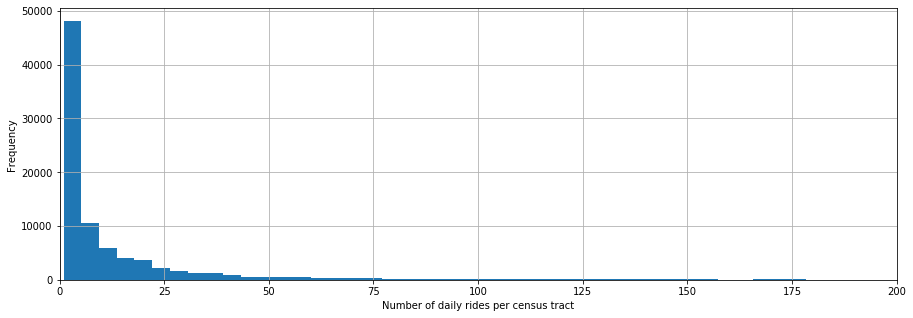

In [99]:
#Overall distribution of rides per day by census tract (5% of data)
fig,ax=plt.subplots(figsize=(15,5))
daily_df['NumRides'].hist(bins=200,ax=ax)
ax.set_xlim([0,200])
ax.set_xlabel('Number of daily rides per census tract')
ax.set_ylabel('Frequency')
#most tracts have a small number of rides

## Look at utilization patterns by date range and census tract

In [100]:
tracts=agg_hourly_all.index.get_level_values(0).unique().tolist()

In [101]:
start_date = datetime(2018, 11, 1)
end_date = datetime(2019, 4,1)
dates = pd.date_range(start_date, end_date, freq='D')
options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Date Range: ',
    orientation='horizontal',
    layout={'width': '500px'}
)

tractselector = widgets.Dropdown(
    options=tracts,
    description='Census Tract: '
)


In [138]:

plt.rcParams['figure.figsize'] = [15, 5]
tractdf=censtracts[['geometry']].copy()
tractdf['Match']=0

#@interact(daterange=selection_range_slider,tract=tractselector)
def plotheatmap(daterange,tract='17031839100'):#  downtown center  #'17031980000' airport
    tractdf['Match']=0
    startdate=daterange[0]
    enddate=daterange[1]
    heatdf0=agg_hourly_all.loc[tract][startdate:enddate]
    heatdf=pd.pivot_table(data=heatdf0,index='DOW',columns='Hour',values='NumRides',aggfunc='sum')
    heatdf.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    heatdf=heatdf.fillna(0)
    fig,axes=plt.subplots(2,1,figsize=(15,7))
    sns.heatmap(heatdf,ax=axes[0])
    tractdf.loc[tractdf.index==tract,'Match']=1
    tractdf.plot(column='Match',ax=axes[1],cmap='viridis_r')
    #ax=sns.heatmap(heatdf)
    #ax.set_title(censdf.loc[tract,'NAME'])

widgets.interact(
    plotheatmap,
    daterange=selection_range_slider,
    tract=tractselector
);


interactive(children=(SelectionRangeSlider(description='Date Range: ', index=(32, 75), layout=Layout(width='50…

In [126]:
tractdf=censtracts[['geometry']]
#tractdf['mytract']=censtracts.index=='17031031300'


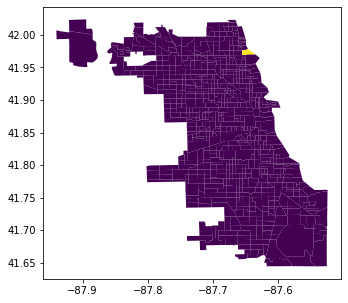

In [124]:
tractdf.plot(column='mytract')

###  Discovered I can download rideshare data in chunks from Chicago Data Portal
* Verified it works with python api and requests package
* Signed up for API key to avoid "throttling"

In [103]:
from sodapy import Socrata #python package for Socrata API
client=Socrata("data.cityofchicago.org",None)
results = client.get("m6dm-c72p", limit=2000,offset=4000)
so_url=r'https://data.cityofchicago.org/resource/m6dm-c72p.json?limit=2000'


In [104]:
r=requests.get(so_url)

In [105]:
r.json()[999]

KeyError: 999